In [1]:
import numpy as np
import math
import statistics
import os
import traceback
from scipy import signal
from scipy import optimize
# import UDIP_4_Lib_V2 as UDIP_Lib_3  #making updating UDIP_Lib easier
import RockSat_1_14_fitting_functions as R_fitting
import json
import matplotlib.pyplot as plt
from RockSat_json import *

## Reset Working Directory

In [2]:
os.chdir(r"C:\Users\jarro\OneDrive - University of Delaware - o365\Courses\DAPPEr\Science Team\Code\DAPPEr_old")

print("Current Directory: " + os.getcwd())

print("Parent Directory: " + os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

Current Directory: C:\Users\jarro\OneDrive - University of Delaware - o365\Courses\DAPPEr\Science Team\Code\DAPPEr_old
Parent Directory: C:\Users\jarro\OneDrive - University of Delaware - o365\Courses\DAPPEr\Science Team\Code


## Get Flight Data

In [3]:
year = 2024
sourceName = 'UDIP123.dat'
#packets = import_data(f'../{year}/{year}_packet.json')
#packets = import_data(f'{year}_packet_FMS_1.json')
packets = import_data('UDIP_4_800s.json')

In [4]:
print(sourceName)
print()
SensNum = len(packets['packets']['Sensor'])
print(f'There are {SensNum} Sensor packets')
print()
LinSweepNum = len(packets['packets']['Full'])
print(f'There are {LinSweepNum} Linear Sweeps')
print()
DensSweepNum = len(packets['packets']['Dense'])
print(f'There are {DensSweepNum} Dense Sweeps')

UDIP123.dat

There are 13701 Sensor packets

There are 903 Linear Sweeps

There are 101 Dense Sweeps


In [8]:
RcktGrndNum = 0
PrbGrndNum = 0

for i in range(0, LinSweepNum):
    if packets['packets']['Full'][f'{i}']['GroundType'] == 0:
        RcktGrndNum += 1
    elif packets['packets']['Full'][f'{i}']['GroundType'] == 1:
        PrbGrndNum += 1

for j in range(0, DensSweepNum):
    if packets['packets']['Dense'][f'{j}']['GroundType'] == 0:
        RcktGrndNum += 1
    elif packets['packets']['Dense'][f'{j}']['GroundType'] == 1:
        PrbGrndNum += 1
        
print(f'There are {RcktGrndNum} Sweeps grounded to the rocket skin')
print(f'There are {PrbGrndNum} Sweeps grounded to the 2nd probe')
    

There are 504 Sweeps grounded to the rocket skin
There are 500 Sweeps grounded to the 2nd probe


## Radar Data

In [5]:
radarTimes = []
altitudes = []
latitudes = []
longitudes = []
with open(r"C:\Users\jarro\OneDrive - University of Delaware - o365\Courses\DAPPEr\Science Team\Code\DAPPEr_old\UDIP4\NRW-6381 ROCKON 41.133 R5 POSDAT 06202024.txt","r") as rockonData:
    next(rockonData) # Skip the header
    for line in rockonData:
        parts = line.strip().split()
        radarTimes.append(float(parts[1])) # time values
        altitudes.append(float(parts[9])/1000) # altitude values in km
        latitudes.append(float(parts[10]))
        longitudes.append(float(parts[11]))

print(len(altitudes))
print(len(radarTimes))
print("Apogee =", max(altitudes))
print("Apogee time =", radarTimes[np.argmax(altitudes)])

6718
6718
Apogee = 114.069
Apogee time = 170.2


In [6]:
targetAltitude = 110  # kilometers


def get_crossing_indices(values, targetValue):
    return np.where(np.diff(np.sign(np.array(values) - targetValue)))[0]


# Return the interpolated time when altitude crosses the target value
def linear_interpolation(time_1, alt_1, time_2, alt_2, target):
    
    return time_1 + (target - alt_1) * (time_2 - time_1) / (alt_2 - alt_1)


def get_crossing_times(targetAlt):
    # Find indices where the altitude crosses the target altitude
    # (When there is a sign change in the difference between the altitude data and the target altitude)
    
    crossing_indices = get_crossing_indices(altitudes, targetAlt)
    
    # For each crossing, interpolate to find the exact time
    crossing_times = []
    for idx in crossing_indices:
        t1, t2 = radarTimes[idx], radarTimes[idx+1]
        a1, a2 = altitudes[idx], altitudes[idx+1]
        crossTime = linear_interpolation(t1, a1, t2, a2, targetAlt)
        crossing_times.append(crossTime)
    
    return crossing_times

    
print("Estimated times at ~",targetAltitude, "km altitude (s):", get_crossing_times(targetAltitude))

Estimated times at ~ 110 km altitude (s): [141.24444444444444, 200.0, 200.0]


## Fitting Functions

In [16]:
def data_processing(V, I):
    #Imax = np.argmax(I) #find index of maximum Current
    Imax = max(I)  # Find the maximum current value
    #print(f'Imax = {Imax}')
    #Imin = np.argmin(I) #find index of minimum Current
    Imin = min(I)  # Find the minimum current value
    #print(f'Imin = {Imin}')

    V_proc = []
    I_proc = []
    for i in range(0,len(V)):
        #if ((V[i] > -0.8) & (V[i] < 0.5)):
        if((I[i] > (Imin + 9e-10)) & (I[i] < (Imax - 9e-10))):
            V_proc.append(V[i])
            I_proc.append(I[i])
    
    return V_proc, I_proc

In [17]:
def slope_fit(V_arr, I_arr, adcNum):
    
    V_proc, I_proc = V_arr, I_arr
    
    if(adcNum == 0):
        guess = [-1e-7, 6.3e-7]    #intial guess (m, b)
        #b = ((-np.inf, -24937.5e-9),(np.inf, 22062.5e-9)) #bounds
        b = ((-np.inf, -np.inf),(np.inf, np.inf)) #bounds
    elif(adcNum == 1):
        guess = [-1e-7, 6.5e-7]    #intial guess (m, b)
        #b = ((-np.inf, -1234.1e-9),(np.inf, 1050.6e-9)) #bounds
        b = ((-np.inf, -np.inf),(np.inf, np.inf)) #bounds
    elif(adcNum == 2):
        guess = [-1e-7, 5.8e-8]    #intial guess (m, b)
        #b = ((-np.inf, -50.03e-9),(np.inf, 58.8e-9)) #bounds
        #b = ((-np.inf, -58.8e-9),(np.inf, 50.03e-9)) #bounds
        #b = ((-np.inf, -5.8e-8),(np.inf, 5.8e-8)) #bounds
        b = ((-np.inf, -np.inf),(np.inf, np.inf)) #bounds
        V_proc, I_proc = data_processing(V_arr, I_arr)

    popt, pcov = optimize.curve_fit(model, V_proc, I_proc, guess, bounds = b)
    
    V_fit = np.linspace(min(V_proc),max(V_proc), num = 300) #Voltage array processed for fit
    return V_fit, model(V_fit,*popt), popt, pcov


def model(V, m1, b):
    return lin_fit(V, m1, b)


def lin_fit(x, m, y_int): # linear fit
    return m * x + y_int

adc0_min = -24937.5e-9  # Amps
adc0_max = 22062.5e-9

acd1_min = -1234.1e-9
adc1_max = 1050.6e-9

adc2_min = -58.8e-9
adc2_max = 50.03e-9


## Sensor Packets

In [7]:
sensorNum = 13700
Sensor = packets['packets']['Sensor'][f'{sensorNum}']

print(Sensor)

{'Start': 799965, 'Stop': 799972, 'Count': 13700, 'Acceleration': [5.208005868175626, 8.445981347584617, -0.272451011212407, [65535]], 'Spin Rate': [0.02349799732977303, 0.01922563417890521, 0.09185580774365822], 'Magnetic Field': [-25.3857421875, -62.7001953125, -15.49072265625], 'Temperature': [41.94871794871794], 'Photo Diode': [0.18842032967032965]}


In [10]:
sensor = packets['packets']['Sensor']
print(len(sensor))
# for i in range(0, len(sensor)):
#     accel = sensor[f'{i}']['Acceleration']
#     print(f'acceleration {i}: {accel}')

13701


In [8]:
sensor = packets['packets']['Sensor']

accX = []
accY = []
accZ = []

accRawX = []
accRawY = []
accRawZ = []


time = []

#launchTime = 57
launchTime = 56

for i in range (0, len(sensor)):
#for i in range (0, 15000):
    accX.append(sensor[f'{i}']['Acceleration'][0])
    accRawX.append(sensor[f'{i}']['Acceleration'][0] * 95.43)
    
    accY.append(sensor[f'{i}']['Acceleration'][1])
    accRawY.append(sensor[f'{i}']['Acceleration'][1] * 95.43)
    
    accZ.append(sensor[f'{i}']['Acceleration'][2])
    accRawZ.append(sensor[f'{i}']['Acceleration'][2] * 95.43)
    
    #time.append(sensor[f'{i}']['Start'] / 1000)
    time.append((sensor[f'{i}']['Start'] / 1000) - launchTime)
    

print(max(accZ))

235.188095986587


In [5]:
print(max(accZ[12000:12500]))
# print(accZ[500:700])

for j in range(0,600):
    if sensor[f'{j}']['Acceleration'][2] >= 10:
        print(f'Launch at time = {time[j]} seconds')
        break

1.0478885046631037
Launch at time = 0.9200000000000017 seconds


In [43]:
accelVsTimeList = []

for i in range(11500,12000):
    accel = round(sensor[f'{i}']['Acceleration'][2], 3)
    time = round((sensor[f'{i}']['Start'] / 1000) - 56.92, 3)
    accelVsTime = [time,accel]
    accelVsTimeList.append(accelVsTime)

#print(accelVsTimeList)
    

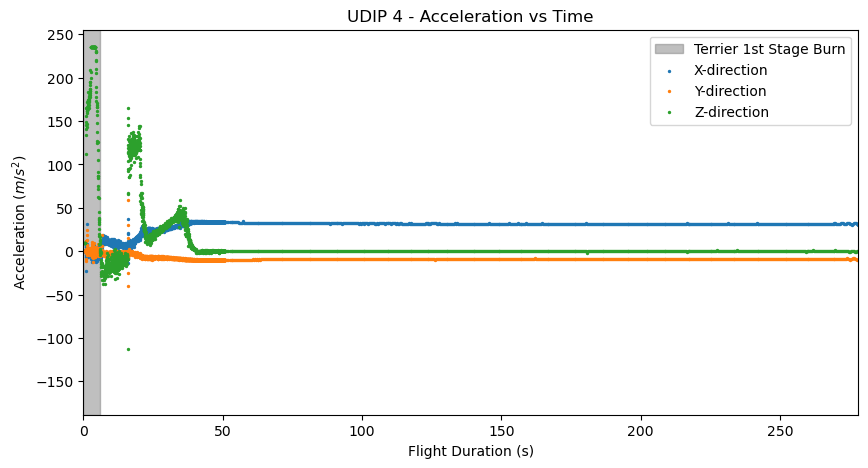

In [9]:
# num = np.linspace(1,len(sensor),len(sensor))

plt.figure(figsize=(10,5))
plt.axvspan(0, 6, color='gray', alpha=0.5, label='Terrier 1st Stage Burn')
plt.scatter(time, accX, label = 'X-direction', s=2)
plt.scatter(time, accY, label = 'Y-direction', s=2)
plt.scatter(time, accZ, label = 'Z-direction', s=2)
plt.title('UDIP 4 - Acceleration vs Time')
plt.ylabel('Acceleration ($m/s^2$)')
plt.xlabel('Flight Duration (s)')
#plt.xlim(-100,800)
plt.xlim(0,278)
#plt.ylim(-50,50)
#plt.grid()
plt.legend()
plt.show()

(0.0, 278.0)

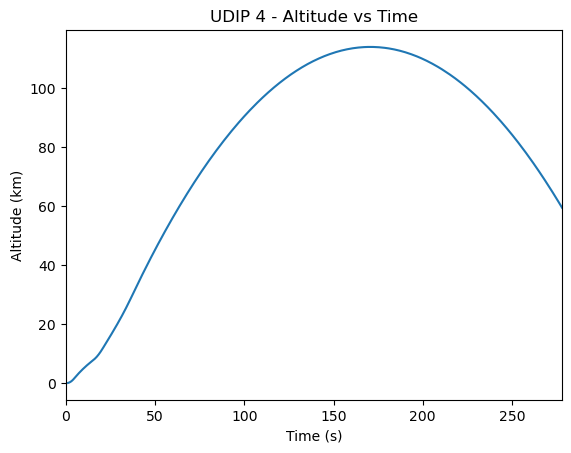

In [10]:
plt.plot(radarTimes,altitudes)
plt.title(r'UDIP 4 - Altitude vs Time')
plt.xlabel("Time (s)")
plt.ylabel('Altitude (km)')
plt.xlim(0,278)

In [23]:
for n in range(0,len(altitudes)):
    if n > 0 and altitudes[n] < altitudes[n-1] and altitudes[n] < 60000:
        print(radarTimes[n])
        break

277.7


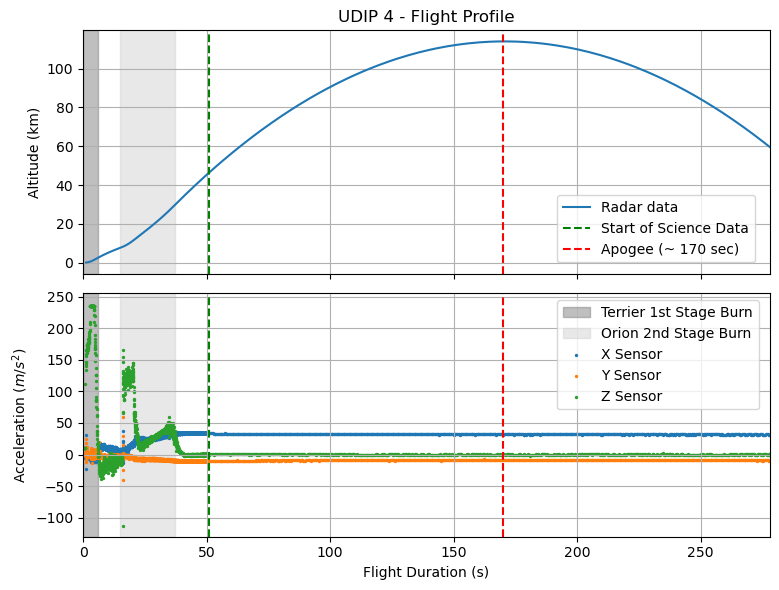

In [11]:
fig, ax = plt.subplots(2, sharex = True, sharey = False, figsize=(8,6))

ax[0].axvspan(0, 6, color='grey', alpha=0.5)
ax[0].axvspan(15, 37, color='lightgrey', alpha=0.5)
ax[0].plot(radarTimes,altitudes, label = 'Radar data')
ax[0].axvline(x = 51, color = "green", linestyle = '--', label = 'Start of Science Data')
ax[0].axvline(x = 170, color = "red", linestyle = '--', label = 'Apogee (~ 170 sec)')
ax[0].set_title('UDIP 4 - Flight Profile')
ax[0].set_ylabel('Altitude (km)')
ax[0].grid()
ax[0].legend(bbox_to_anchor=(0.68, 0.35), loc='upper left')

ax[1].axvspan(0, 6, color='grey', alpha=0.5, label='Terrier 1st Stage Burn')
ax[1].axvspan(15, 37, color='lightgrey', alpha=0.5, label='Orion 2nd Stage Burn')
ax[1].scatter(time, accX, label = 'X Sensor', s=2)
ax[1].scatter(time, accY, label = 'Y Sensor', s=2)
ax[1].scatter(time, accZ, label = 'Z Sensor', s=2)
ax[1].axvline(x = 51, color = "green", linestyle = '--')
ax[1].axvline(x = 170, color = "red", linestyle = '--')
ax[1].set_xlim(0,278)
ax[1].set_ylim(-130,255)
ax[1].set_xlabel('Flight Duration (s)')
ax[1].set_ylabel('Acceleration ($m/s^2$)')
ax[1].grid()
ax[1].legend(bbox_to_anchor=(0.68, 1.0), loc='upper left')

fig.tight_layout()
plt.show()

In [12]:
 """
 Calculate the great-circle distance between two points on the Earth.
 All latitudes and longitudes are expected in decimal degrees.
 Returns the distance in meters.
 """

def get_arc_distance(lat_1, long_1, lat_2, long_2):
    
    # Convert decimal degrees to radians
    lat_1, long_1, lat_2, long_2 = map(np.radians, [lat_1, long_1, lat_2, long_2])
    
    # Differences
    diff_lat = lat_2 - lat_1
    diff_long = long_2 - long_1
    
    # Haversine formula (Calculates the arc distance between 2 points in a great circle)
    a = np.sin(diff_lat / 2.0)**2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(diff_long / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Earth radius in meters
    r = 6371000
    
    # Great Circle distance in km
    return (c * r) / 1000


# Use the first data point as the launch site coordinates.
launch_lat = latitudes[0]
launch_long = longitudes[0]

# Calculate the horizontal distance from the launch site for each point.
radarDistance = get_arc_distance(launch_lat, launch_long, latitudes, longitudes)

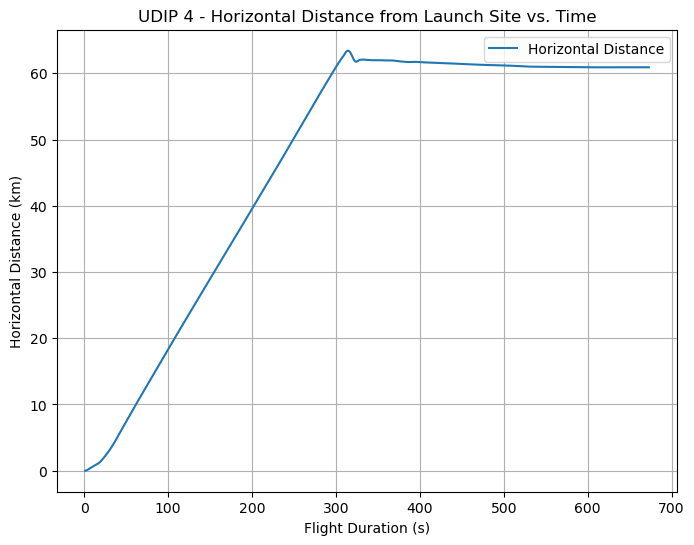

In [13]:
# Plot of Horizontanl Distance vs Time
plt.figure(figsize=(8, 6))
plt.plot(radarTimes, radarDistance, label='Horizontal Distance')
plt.xlabel("Flight Duration (s)")
plt.ylabel("Horizontal Distance (km)")
plt.title("UDIP 4 - Horizontal Distance from Launch Site vs. Time")
plt.grid(True)
plt.legend()
plt.show()

In [16]:
# Horizontal distance between two times during flight
def get_dist_between_times(targetTime1, targetTime2):
    index1 = get_crossing_indices(radarTimes,targetTime1)
    index1 = index1[len(index1)-1]
    index2 = get_crossing_indices(radarTimes,targetTime2)
    index2 = index2[len(index2)-1]
    
    time1 = radarTimes[index1]
    time2 = radarTimes[index2]
    
    latitude1 = latitudes[index1]
    longitude1 = longitudes[index1]
    
    latitude2 = latitudes[index2]
    longitude2 = longitudes[index2]
    
    print(time1, "to ", time2,"seconds")
    print("(",latitude1,",",longitude1,") to (",latitude2,",",longitude2,"):")
    print("Arc Distance = ", get_arc_distance(latitude1,longitude1,latitude2,longitude2), "Kilometers")
    
    #return get_arc_distance(latitude1,longitude1,latitude2,longitude2)
    
#print(get_crossing_indices(radarTimes,141.244))
#print(get_crossing_indices(radarTimes,200))
get_dist_between_times(141.24, 200)

141.2 to  200.0 seconds
( 37.7789552 , -75.1827315 ) to ( 37.7497832 , -75.0464095 ):
Arc Distance =  12.414467191510958 Kilometers


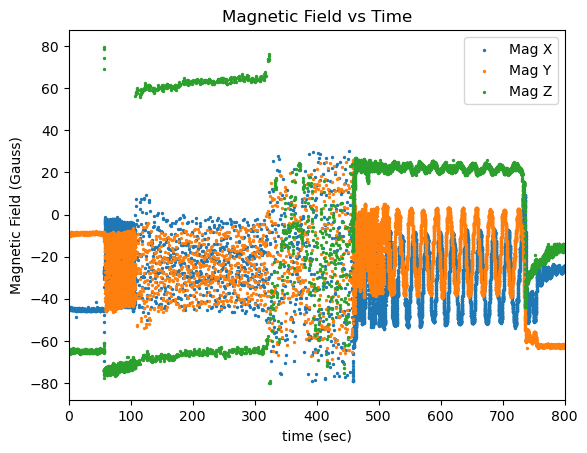

In [24]:
sensor = packets['packets']['Sensor']

magX = []
magY = []
magZ = []

magRawX = []
magRawY = []
magRawZ = []

time = []

for i in range (0, 15000):
    magX.append(sensor[f'{i}']['Magnetic Field'][0])
    magRawX.append(sensor[f'{i}']['Magnetic Field'][0] * 409.6)
    
    magY.append(sensor[f'{i}']['Magnetic Field'][1])
    magRawY.append(sensor[f'{i}']['Magnetic Field'][1] * 409.6)
    
    magZ.append(sensor[f'{i}']['Magnetic Field'][2])
    magRawZ.append(sensor[f'{i}']['Magnetic Field'][2] * 409.6)
    
    
    time.append(sensor[f'{i}']['Start'] / 1000)
    

plt.scatter(time, magX, label = 'Mag X', s=2)
plt.scatter(time, magY, label = 'Mag Y', s=2)
plt.scatter(time, magZ, label = 'Mag Z', s=2)
plt.title('Magnetic Field vs Time')
plt.ylabel('Magnetic Field (Gauss)')
plt.xlabel('time (sec)')
plt.xlim(0,800)
plt.legend()
plt.show()

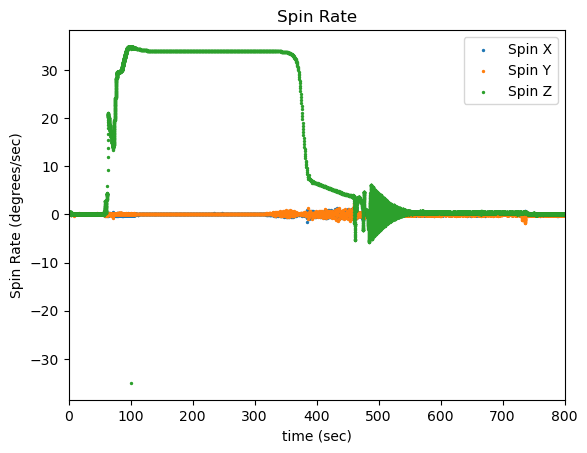

In [28]:
sensor = packets['packets']['Sensor']

spinX = []
spinY = []
spinZ = []

spinXRaw = []
spinYRaw = []
spinZRaw = []

time = []

for i in range (0, 15000):
    spinX.append(sensor[f'{i}']['Spin Rate'][0])
    spinXRaw.append(sensor[f'{i}']['Spin Rate'][0] * 936.25)
    
    spinY.append(sensor[f'{i}']['Spin Rate'][1])
    spinYRaw.append(sensor[f'{i}']['Spin Rate'][1] * 936.25)
    
    spinZ.append(sensor[f'{i}']['Spin Rate'][2])
    spinZRaw.append(sensor[f'{i}']['Spin Rate'][2] * 936.25)
    
    time.append(sensor[f'{i}']['Start'] / 1000)


plt.scatter(time, spinX, label = 'Spin X', s=2)
plt.scatter(time, spinY, label = 'Spin Y', s=2)
plt.scatter(time, spinZ, label = 'Spin Z', s=2)
plt.title('Spin Rate')
plt.ylabel('Spin Rate (degrees/sec)')
plt.xlabel('time (sec)')
plt.xlim(0,800)
plt.legend()
plt.show()

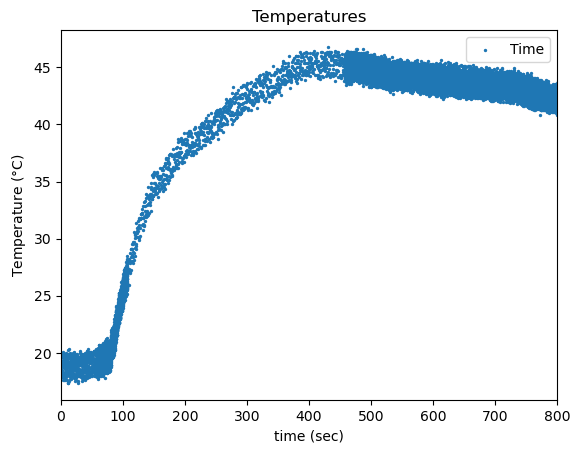

In [32]:
sensor = packets['packets']['Sensor']

temps = []

time = []

for i in range (0, 15000):
    temps.append(sensor[f'{i}']['Temperature'][0])
    
    time.append(sensor[f'{i}']['Start'] / 1000)
    

plt.scatter(time, temps, label = 'Time', s=2)
plt.title('Temperatures')
plt.ylabel('Temperature ($\degree$C)')
plt.xlabel('time (sec)')
plt.xlim(0,800)
plt.legend()
plt.show()


## Voltage Sweeps

In [4]:
FullSweeps = packets['packets']['Full']
DenseSweeps = packets['packets']['Dense']

timeFull = []
timeDens = []

for i in range(0, len(FullSweeps)):
    timeFull.append(FullSweeps[f'{i}']['Start'] / 1000)
    
for i in range(1, len(DenseSweeps)):
    timeDens.append(DenseSweeps[f'{i}']['Start'] / 1000)

print(f'There are {len(FullSweeps)} Full sweeps.')
print(f'They start at {min(timeFull)} seconds and end at {max(timeFull)} seconds.')
print()
print(f'There are {len(DenseSweeps)} Dense sweeps.')
print(f'They start at {min(timeDens)} seconds and end at {max(timeDens)} seconds.')

There are 903 Full sweeps.
They start at 107.677 seconds and end at 459.514 seconds.

There are 101 Dense sweeps.
They start at 111.216 seconds and end at 458.464 seconds.


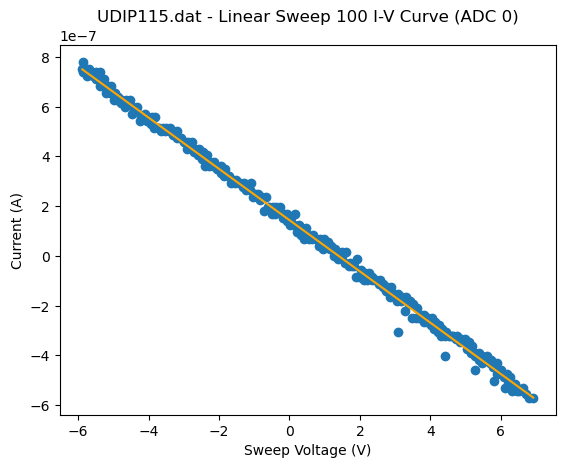

ADC_0 Slope = -1.0316e-07
ADC_0 Standard Error = 3.9982e-10


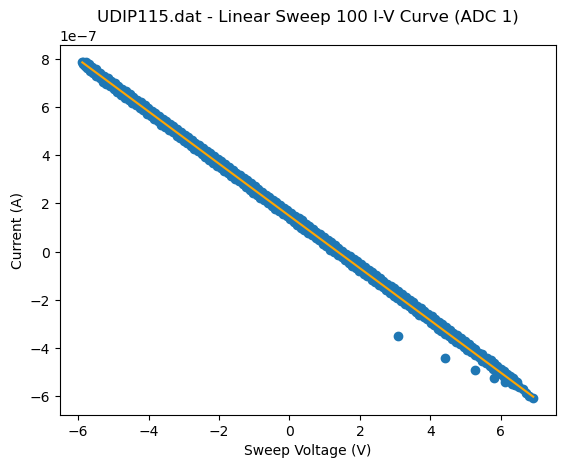

ADC_1 Slope = -1.0829e-07
ADC_1 Standard Error = 4.1239e-10


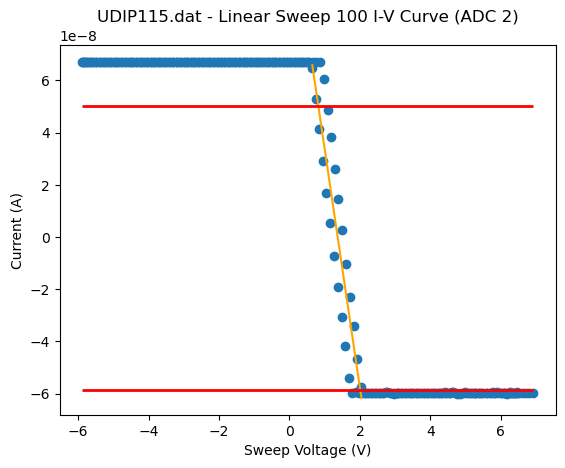

ADC_2 Slope = -9.1490e-08
ADC_2 Standard Error = 9.3155e-09


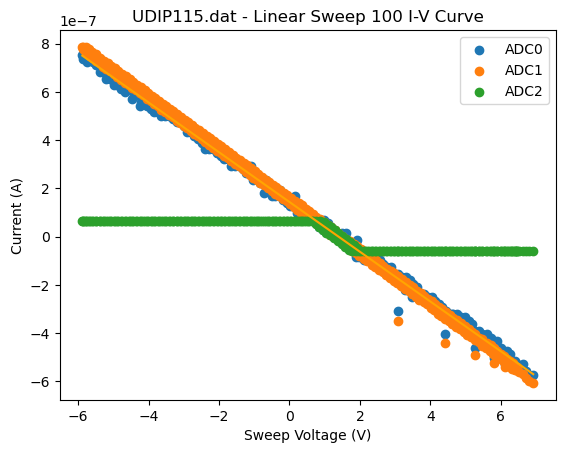

ADC_0 Slope = -1.0316e-07
ADC_1 Slope = -1.0829e-07
ADC_2 Slope = -9.1490e-08

ADC_0 Standard Error = 3.9982e-10
ADC_1 Standard Error = 4.1239e-10
ADC_2 Standard Error = 9.3155e-09


In [7]:
sweepNum = 100
V = packets['packets']['Full'][f'{sweepNum}']['Voltage']
I0 = packets['packets']['Full'][f'{sweepNum}']['Current0']
I1 = packets['packets']['Full'][f'{sweepNum}']['Current1']
I2 = packets['packets']['Full'][f'{sweepNum}']['Current2']

# num = np.linspace(1,len(I2),len(I2))
# plt.scatter(num,I2)
# plt.title(f'{sourceName} - Linear Sweep {sweepNum} - ADC 2 Values in order')
# plt.show()

# num = np.linspace(1,len(V),len(V))
# plt.scatter(num,V)
# plt.title(f'{sourceName} - Linear Sweep {sweepNum} - Voltage Values in order')
# plt.show()

plt.scatter(V[1:],I0[1:])
x, y, popt, pcov = slope_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve (ADC 0)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_0 = "{:.4e}".format(popt[0])
std_err_0 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_0 Standard Error = {std_err_0}')

plt.scatter(V[1:],I1[1:])
x, y, popt, pcov = slope_fit(V, I1, 1) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve (ADC 1)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_1 = "{:.4e}".format(popt[0])
std_err_1 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_1 Standard Error = {std_err_1}')

plt.scatter(V[1:],I2[1:])
x, y, popt, pcov = slope_fit(V, I2, 2) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.hlines(y=adc2_max, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.hlines(y=adc2_min, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve (ADC 2)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_2 = "{:.4e}".format(popt[0])
std_err_2 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_2 Slope = {slope_2}')
print(f'ADC_2 Standard Error = {std_err_2}')


plt.scatter(V[1:],I0[1:], label = "ADC0")
plt.scatter(V[1:],I1[1:], label = "ADC1")
plt.scatter(V[1:],I2[1:], label = "ADC2")
x, y, popt, pcov = slope_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()


print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_2 Slope = {slope_2}')
print()
print(f'ADC_0 Standard Error = {std_err_0}')
print(f'ADC_1 Standard Error = {std_err_1}')
print(f'ADC_2 Standard Error = {std_err_2}')

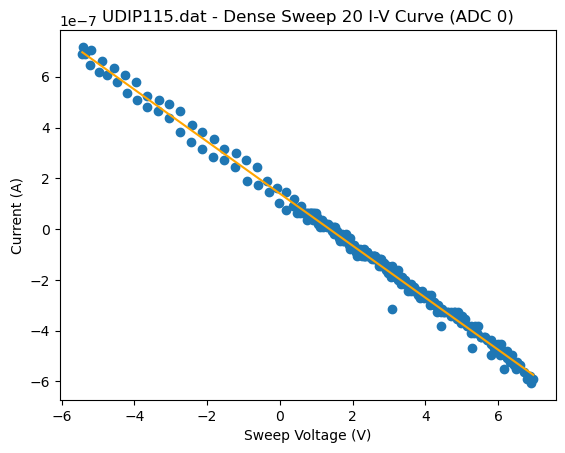

ADC_0 Slope = -1.0247e-07
ADC_0 Standard Error = 5.3278e-10


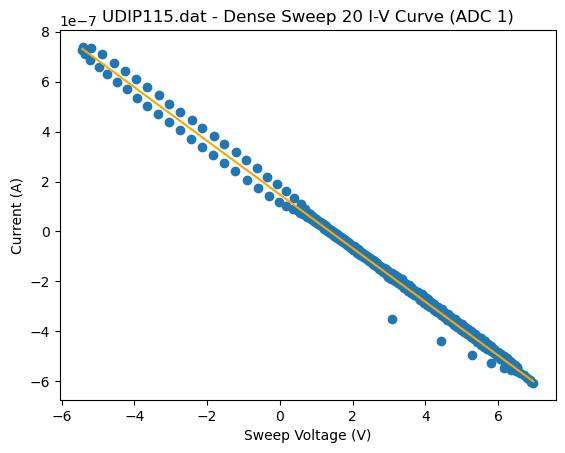

ADC_1 Slope = -1.0746e-07
ADC_1 Standard Error = 5.8075e-10


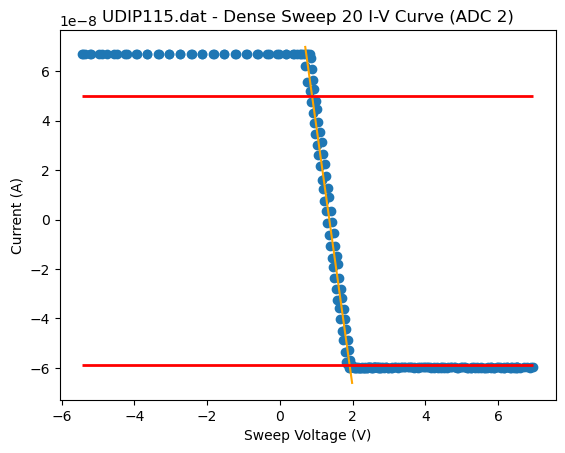

ADC_2 Slope = -1.0549e-07
ADC_2 Standard Error = 2.8511e-09


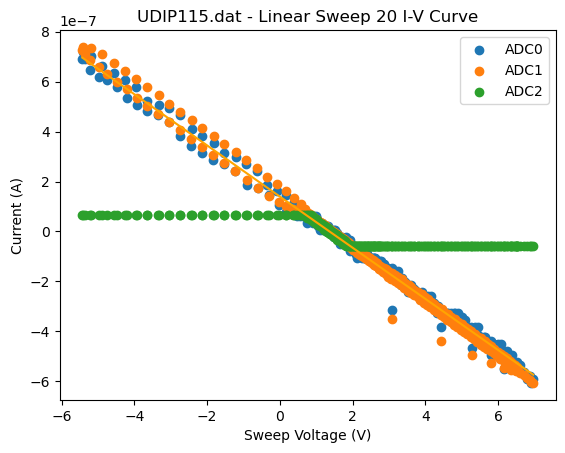

ADC_0 Slope = -1.0247e-07
ADC_1 Slope = -1.0746e-07
ADC_2 Slope = -1.0549e-07

ADC_0 Standard Error = 5.3278e-10
ADC_1 Standard Error = 5.8075e-10
ADC_2 Standard Error = 2.8511e-09


In [7]:
sweepNum = 20
V = packets['packets']['Dense'][f'{sweepNum}']['Voltage']
I0 = packets['packets']['Dense'][f'{sweepNum}']['Current0']
I1 = packets['packets']['Dense'][f'{sweepNum}']['Current1']
I2 = packets['packets']['Dense'][f'{sweepNum}']['Current2']

# num = np.linspace(1,len(I0),len(I0))
# plt.scatter(num,I0)
# plt.title(f'{sourceName} - Dense Sweep {sweepNum} - ADC 0 Values in order')
# plt.show()

plt.scatter(V[1:],I0[1:])
x, y, popt, pcov = slope_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Dense Sweep {sweepNum} I-V Curve (ADC 0)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_0 = "{:.4e}".format(popt[0])
std_err_0 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_0 Standard Error = {std_err_0}')

plt.scatter(V[1:],I1[1:])
x, y, popt, pcov = slope_fit(V, I1, 1) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Dense Sweep {sweepNum} I-V Curve (ADC 1)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_1 = "{:.4e}".format(popt[0])
std_err_1 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_1 Standard Error = {std_err_1}')

plt.scatter(V[1:],I2[1:])
x, y, popt, pcov = slope_fit(V, I2, 2) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.hlines(y=adc2_max, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.hlines(y=adc2_min, xmin=min(V), xmax=max(V), linewidth=2, color='r')
plt.title(f'{sourceName} - Dense Sweep {sweepNum} I-V Curve (ADC 2)')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.show()
slope_2 = "{:.4e}".format(popt[0])
std_err_2 = "{:.4e}".format(np.sqrt(np.diag(pcov)[0]))
print(f'ADC_2 Slope = {slope_2}')
print(f'ADC_2 Standard Error = {std_err_2}')


plt.scatter(V[1:],I0[1:], label = "ADC0")
plt.scatter(V[1:],I1[1:], label = "ADC1")
plt.scatter(V[1:],I2[1:], label = "ADC2")
x, y, popt, pcov = slope_fit(V, I0, 0) # x is V, y is I
plt.plot(x, y, color = 'orange')
plt.title(f'{sourceName} - Linear Sweep {sweepNum} I-V Curve')
plt.xlabel('Sweep Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()


print(f'ADC_0 Slope = {slope_0}')
print(f'ADC_1 Slope = {slope_1}')
print(f'ADC_2 Slope = {slope_2}')
print()
print(f'ADC_0 Standard Error = {std_err_0}')
print(f'ADC_1 Standard Error = {std_err_1}')
print(f'ADC_2 Standard Error = {std_err_2}')


In [11]:
FullSweeps = packets['packets']['Full']
#DenseSweeps = packets['packets']['Dense']

startTimes = []

stopTimes = []

fullSweepDurations = []

timesBetweenSweeps = []

totalSweepDuration = 0
totalTimeBetween = 0

for i in range(0, len(FullSweeps)):
    
    startTime = FullSweeps[f'{i}']['Start']
    
    if i > 0:
        prevStopTime = stopTime
        totalTimeBetween += (startTime - prevStopTime)
        timesBetweenSweeps.append(startTime - prevStopTime)
    
    stopTime = FullSweeps[f'{i}']['Stop']
    
    startTimes.append(startTime)
    stopTimes.append(stopTime)
    
    fullSweepDurations.append(stopTime-startTime)
    totalSweepDuration += (stopTime-startTime)
    
    

avgDuration = totalDuration / len(FullSweeps)
    
medDuration = statistics.median(fullSweepDurations)
    
avgTimeBetween = totalTimeBetween / len(FullSweeps)

medTimeBetween = statistics.median(timesBetweenSweeps)

timeElapsed = max(stopTimes) - min(startTimes)

print(f'The average sweep duration is {avgDuration} ms.')
print()
print(f'The median sweep duration is {medDuration} ms.')
print()
print(f'The total sweep duration is {totalSweepDuration} ms, out of {timeElapsed} ms of time elapsed.')
print()
print(f'The average time between sweeps is {avgTimeBetween} ms.')
print()
print(f'The median time between sweeps is {medTimeBetween} ms.')
print()
print(f'The total time between sweeps is {totalTimeBetween} ms, out of {timeElapsed} ms of time elapsed.')

The average sweep duration is 472.8737541528239 ms.

The median sweep duration is 467 ms.

The total sweep duration is 427005 ms, out of 352303 ms of time elapsed.

The average time between sweeps is -82.7264673311185 ms.

The median time between sweeps is -122.0 ms.

The total time between sweeps is -74702 ms, out of 352303 ms of time elapsed.


In [14]:
FullSweeps = packets['packets']['Full']
#DenseSweeps = packets['packets']['Dense']

voltStepDifferences = []

avgVoltStepDifferences = []

medVoltStepDifferences = []

totalVoltChange = 0

localVoltChanges = []

for i in range(0, len(FullSweeps)):
    
    sweep = FullSweeps[f'{i}']['Voltage']
    
    voltStepDifferences = []
    
    localVoltChange = 0
    
    for j in range(0, len(sweep)):
        
        if j > 0:
            prevVoltStep = voltageStep
            voltageStep = sweep[j]
            voltStepDifferences.append(abs(voltageStep - prevVoltStep))
            localVoltChange += abs(voltageStep - prevVoltStep)
        else:
            voltageStep = sweep[j]
    
    avgVoltStep = localVoltChange / len(sweep)
    avgVoltStepDifferences.append(avgVoltStep)
    
    medVoltStepDifferences.append(statistics.median(voltStepDifferences))
    
    localVoltChanges.append(localVoltChange)
    totalVoltChange += localVoltChange
        

avgVoltChange = totalVoltChange / len(FullSweeps)

medVoltChange = statistics.median(localVoltChanges)

medAvgVoltStep = statistics.median(avgVoltStepDifferences)

medMedVoltStep = statistics.median(medVoltStepDifferences)

print(f'The average voltage sweep range {avgVoltChange} V.')
print()
print(f'The median voltage sweep range {medVoltChange} V.')
print()
print(f'The median average voltage step is {medAvgVoltStep} V.')
print()
print(f'The median median voltage step is {medMedVoltStep} V.')
print()

The average voltage sweep range 30.488125278072765 V.

The median voltage sweep range 30.4849706744868 V.

The median average voltage step is 0.11908191669721406 V.

The median median voltage step is 0.10447214076246247 V.

